<a href="https://colab.research.google.com/github/johannanguyen/nfl_stats/blob/master/nfl_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep
---

This code imports the necessary libraries and sets up a web scraping function to retrieve NFL statistics from nfl.com using BeautifulSoup. The function takes two required arguments - the statistical category (passing, rushing, or receiving) and a 4-digit year. It constructs the appropriate URL and scrapes the data from the website's tables to convert into a pandas dataframe.

In [64]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp, f_oneway, spearmanr, ttest_ind
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sb

In [65]:
def import_table(category, year):
  url = f"https://www.nfl.com/stats/player-stats/category/{category}/{year}/reg/all/{category}yards/desc"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  table = soup.find("table")
  results = pd.read_html(StringIO(str(table)))[0]

  return results

# Passing
---

## Do efficient passers have better ratings?

**Pearson Correlation Coefficient:** Yes.

The data shows that quarterbacks who throw for more yards per attempt tend to have higher QB ratings. This relationship is strong and statistically meaningful. The correlation coefficient measures how closely these two stats move together, and the p-value confirms this pattern is real, not coincidental.

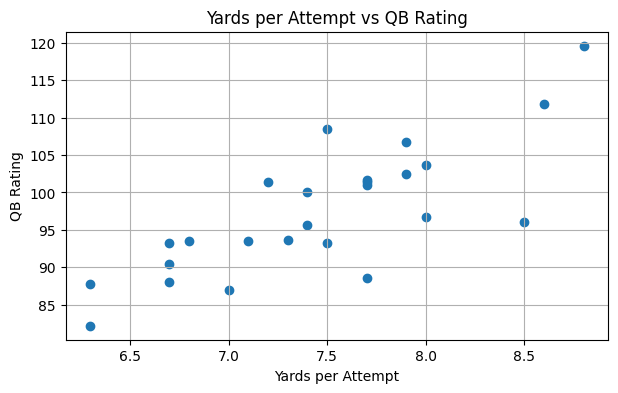


Pearson Correlation Coefficient: 0.7822212120035172 ✅
P value: 3.853214337575798e-06 ✅



In [66]:
qb_2024 = import_table("passing", "2024")

# Yards per Attempt vs QB Rating Graph
x = qb_2024['Yds/Att']
y = qb_2024['Rate']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)

plt.xlabel("Yards per Attempt")
plt.ylabel("QB Rating")
plt.title("Yards per Attempt vs QB Rating")
plt.grid(True)
plt.show()

# Statistical Evidence
# Pearson Correlation Coefficient ranges between [-1, 1]; measures strength/direction of relationship
# p value tests statistical significance; < 0.05 unlikely to be coincidental
pcc, p_value =  pearsonr(qb_2024['Yds/Att'], qb_2024['Rate'])
print(f"\nPearson Correlation Coefficient: {pcc} ✅")
print(f"P value: {p_value} ✅\n")

## Do high-volume QBs score more TDs?

**T-Test:** Yes

The T-statistic shows there's a meaningful difference between groups. The p-value confirms this isn't just luck - it's a real pattern in the data. There is a significant positive correlation between high-volume QBs and number of TDs scored.

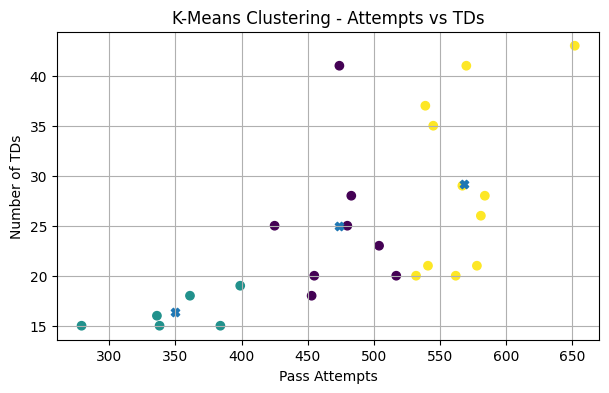

## Using the T-test

T-statistic: 2.207793806091292
p-value: 0.037503667873498514


In [67]:
# Yards per Attempt vs QB Rating Graph
# Include KMeans clustering
x = qb_2024['Att']
y = qb_2024['TD']

# Combine both columns into a 2D array for KMeans()
X = np.column_stack((x, y))

# Use 3 clusters, pick 3 centroids, assign each point to a centroid
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(7, 4))

# Use label to color each point
scatter = plt.scatter(x, y, c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="X")

plt.xlabel("Pass Attempts")
plt.ylabel("Number of TDs")
plt.title("K-Means Clustering - Attempts vs TDs")
plt.grid(True)
plt.show()

# T-test
# The further from 0 the T-statistic, the larger the difference
# p value tests statistical significance; < 0.05 unlikely to be coincidental
display(Markdown("## Using the T-test"))
median_att = qb_2024['Att'].median()
high_volume = qb_2024[qb_2024['Att'] > median_att]['TD']
low_volume = qb_2024[qb_2024['Att'] <= median_att]['TD']
t_stat, p_value = ttest_ind(high_volume, low_volume)

print(f"T-statistic: {t_stat:}\np-value: {p_value}")

## What is the trade-off between aggressive scoring and turnovers?

**T-test, Lineaar Regression:** QBs who throw more touchdowns do throw slightly more interceptions, but the relationship is weak. The positive slope shows there's some risk-reward trade-off since more aggressive play leads to both more TDs and more turnovers but it's minimal. You can be aggressive without dramatically increasing turnovers.

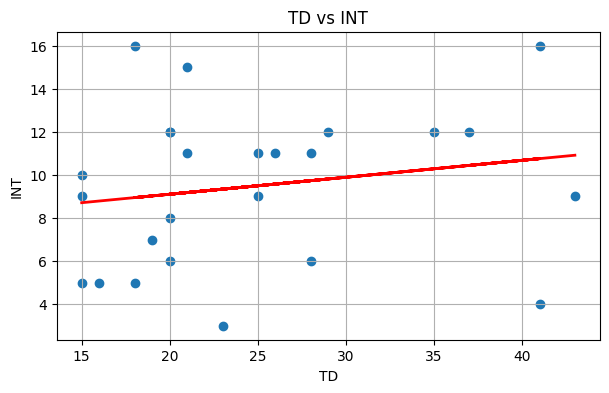

Slope: 0.07870517296096477
Intercept: 7.531259917486513


In [68]:
# TD vs INT Graph
x = qb_2024['TD']
y = qb_2024['INT']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)
plt.xlabel("TD")
plt.ylabel("INT")
plt.title("TD vs INT")
plt.grid(True)

# Linear Regression
x = qb_2024[['TD']].values
y = qb_2024['INT'].values
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red', linewidth=2, label='Regression line')  # Regression line
plt.show()

# If slope is positive, more risk = more reward
# Intercept is the expected number of INTs when a QB throws 0 TDs
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

# Rushing
---

## Do top running backs get most of their yards from short runs or do long runs make a big difference?

**One Sample T-test:** Using 40+ yard runs as "long" runs, the data shows that these big plays make up far less than 3% of running backs' total yards. The average is actually 17 standard deviations below 3%, which is extremely low. Running backs get the vast majority of their yards from consistent short runs rather than occasional explosive breakaway plays. The long highlight-reel runs look impressive but don't actually contribute much to a back's total production.

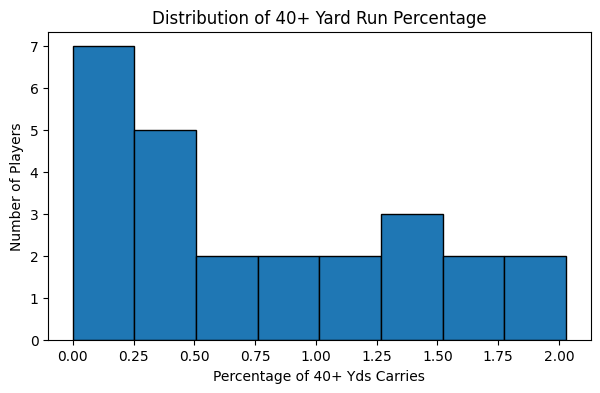

T-statistic: -17.092433393356306 
P-value: 6.121933246658784e-15



In [69]:
rushing_2024 = import_table("rushing", "2024")

# Percentage of 40+ out of all attempts graph
rushing_2024["40+%"] = (rushing_2024["40+"] / rushing_2024["Att"]) * 100
plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["40+%"], bins=8, edgecolor='black')
plt.title("Distribution of 40+ Yard Run Percentage")
plt.xlabel("Percentage of 40+ Yds Carries")
plt.ylabel("Number of Players")
plt.show()

# Check if average 40+ yard run rate is < 3%
test_value = 3.0
t_stat, p_value = stats.ttest_1samp(rushing_2024['40+%'], test_value)
print(f"T-statistic: {t_stat} ")
print(f"P-value: {p_value:}\n")


## How efficient are running backs on a per-carry basis?

**One Sample T-test:** Using 4 yards per carry as the benchmark for efficiency, the data shows that running backs are performing significantly above this standard. The statistical test confirms they're averaging meaningfully more than 4 yards per carry.

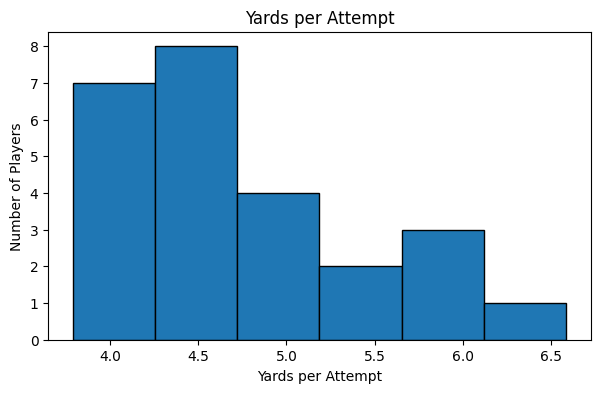

T-statistic: 5.2229
P-value: 0.0000


In [70]:
# Yards Per Attempt graph
rushing_2024["YdsPerAtt"] = rushing_2024["Rush Yds"] / rushing_2024["Att"]

plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["YdsPerAtt"], bins=6, edgecolor="black")
plt.title("Yards per Attempt")
plt.xlabel("Yards per Attempt")
plt.ylabel("Number of Players")
plt.show()


# Run one-sample t-test
t_stat, p_value = ttest_1samp(rushing_2024['YdsPerAtt'], 4.0)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Receiving

## Do Wide Receivers with more targets have different yards per reception?

**One-Way ANOVA:** Wide receiver efficiency varies significantly based on target volume. The statistical analysis shows strong evidence that high-target receivers are less efficient per catch, typically functioning as possession receivers running shorter routes, while low-target receivers tend to be more explosive deep threats who average more yards per reception despite fewer opportunities.

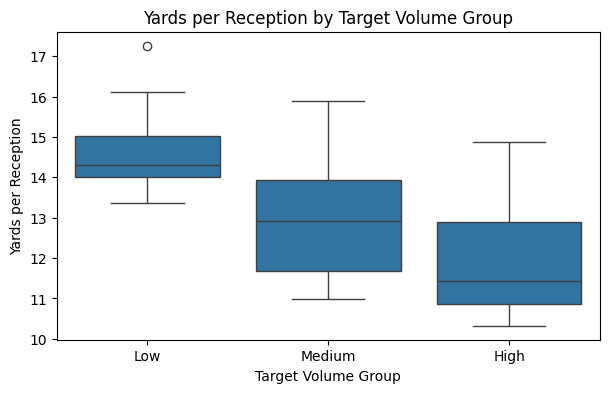

ANOVA: F-stat = 7.1832, p = 0.0040


In [71]:
receiving_2024 = import_table("receiving", "2024")

# Add Yards per Reception column
receiving_2024["YdsPerRec"] = receiving_2024["Yds"] / receiving_2024["Rec"]

# Bin players by target volume (low, medium, high)
receiving_2024["TargetGroup"] = pd.qcut(receiving_2024["Tgts"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(7,4))
sb.boxplot(x="TargetGroup", y="YdsPerRec", data=receiving_2024)
plt.title("Yards per Reception by Target Volume Group")
plt.xlabel("Target Volume Group")
plt.ylabel("Yards per Reception")
plt.show()

low = receiving_2024[receiving_2024["TargetGroup"] == "Low"]["YdsPerRec"]
medium = receiving_2024[receiving_2024["TargetGroup"] == "Medium"]["YdsPerRec"]
high = receiving_2024[receiving_2024["TargetGroup"] == "High"]["YdsPerRec"]

# ANOVA
anova_stat, anova_p = f_oneway(low, medium, high)
print(f"ANOVA: F-stat = {anova_stat:.4f}, p = {anova_p:.4f}")


## How does yards after catch per reception vary across receivers?

**Spearman Correlation:** The analysis shows virtually no relationship between how many targets a receiver gets and their touchdown production. With a p-value of 0.6440, this finding is not statistically significant. This means getting more targets does not translate to more touchdowns. High-volume possession receivers do not necessarily score more than explosive deep threats who get fewer targets.

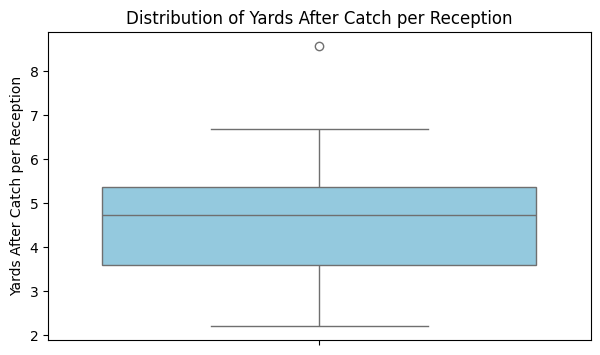

Spearman correlation: 0.0972
P-value: 0.6440


In [72]:
receiving_2024["YACperRec"] = receiving_2024["Rec YAC/R"] / receiving_2024["Rec"]

plt.figure(figsize=(7, 4))
sb.boxplot(y="YACperRec", data=receiving_2024, color="skyblue")
plt.title("Distribution of Yards After Catch per Reception")
plt.ylabel("Yards After Catch per Reception")
plt.show()

# Compute Spearman correlation directly from the DataFrame
spearman_corr, p_value = spearmanr(receiving_2024["Tgts"], receiving_2024["TD"])

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")